Import libraries

In [54]:
import requests
import numpy as np
import json
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import warnings
from scipy.stats.stats import pearsonr
import scipy as sp
from scipy import stats
from scipy.stats import skew,norm
from sklearn.preprocessing import PolynomialFeatures
plt.style.use('seaborn')
from scipy.stats import chi2_contingency
from scipy.stats import chi2

Import data from kaggle

In [55]:
df = pd.read_csv("AB_NYC_2019.csv")  #Loading in the csv file into a Pandas Data Frame

## Data Cleaning

Finding and removing NaN values

In [56]:
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [57]:
df.shape #Looking at how many rows we have

(48895, 16)

In [58]:
df.dropna(inplace = True)  #removing all nan values

In [59]:
df.shape  #checking to see if the data frame was reduced in size after dropping the NaN values

(38821, 16)

In [60]:
df.drop(columns= ['id', 'host_id', 'name','host_name','last_review'], inplace= True) #dropping unnecissary columns

In [61]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
5,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,1,129


## Feature Engineering

Lets put the latitude and longitude together to have a column of each airbnb's geolocation

In [62]:
location_coord = list(zip(df.latitude, df.longitude))

In [63]:
df['coordinates']= location_coord

How far is each airbnb from NYC's top attraction Times Square?

In [64]:
times_square_geo= [40.7559, -73.9871] #Times Square Geolocation

Make an API to GeoPandas to find the distance between each airbnb and times square

In [65]:
from geopy.distance import distance
df['dist_from_TS']= df.coordinates.apply(lambda x: distance(x, times_square_geo).miles)

Are any features Collinear?

In [66]:
df_corr_matrix = df.corr() 
df_corr_matrix  #computed a correlation matrix for data set to see if it suggested that any features were collinear

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,dist_from_TS
latitude,1.000000,0.088259,0.031344,0.024893,-0.008559,-0.010117,0.004340,-0.021921,-0.374010
longitude,0.088259,1.000000,-0.155298,-0.055414,0.054746,0.146228,-0.093348,0.102573,0.554798
price,0.031344,-0.155298,1.000000,0.025501,-0.035924,-0.030623,0.052895,0.078276,-0.187586
minimum_nights,0.024893,-0.055414,0.025501,1.000000,-0.069366,-0.121712,0.073474,0.101658,-0.071861
number_of_reviews,-0.008559,0.054746,-0.035924,-0.069366,1.000000,0.549699,-0.059796,0.193409,0.049088
reviews_per_month,-0.010117,0.146228,-0.030623,-0.121712,0.549699,1.000000,-0.009442,0.185896,0.113755
calculated_host_listings_count,0.004340,-0.093348,0.052895,0.073474,-0.059796,-0.009442,1.000000,0.182981,-0.077762
availability_365,-0.021921,0.102573,0.078276,0.101658,0.193409,0.185896,0.182981,1.000000,0.122783
dist_from_TS,-0.374010,0.554798,-0.187586,-0.071861,0.049088,0.113755,-0.077762,0.122783,1.000000


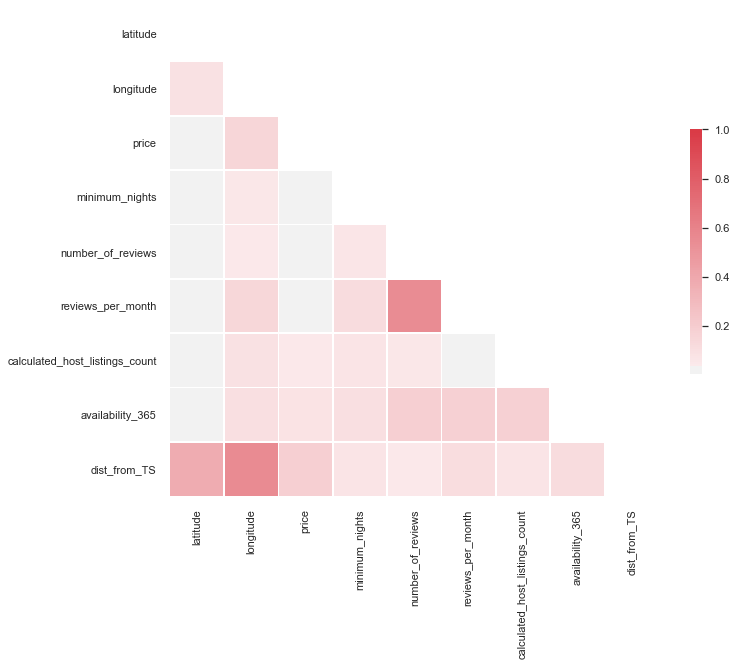

In [67]:
sns.set(style="white")  #using a heat map to display the visuals for the correlations in the dataset
# Compute the correlation matrix
corr = np.abs(df.corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

Are there any outliers?

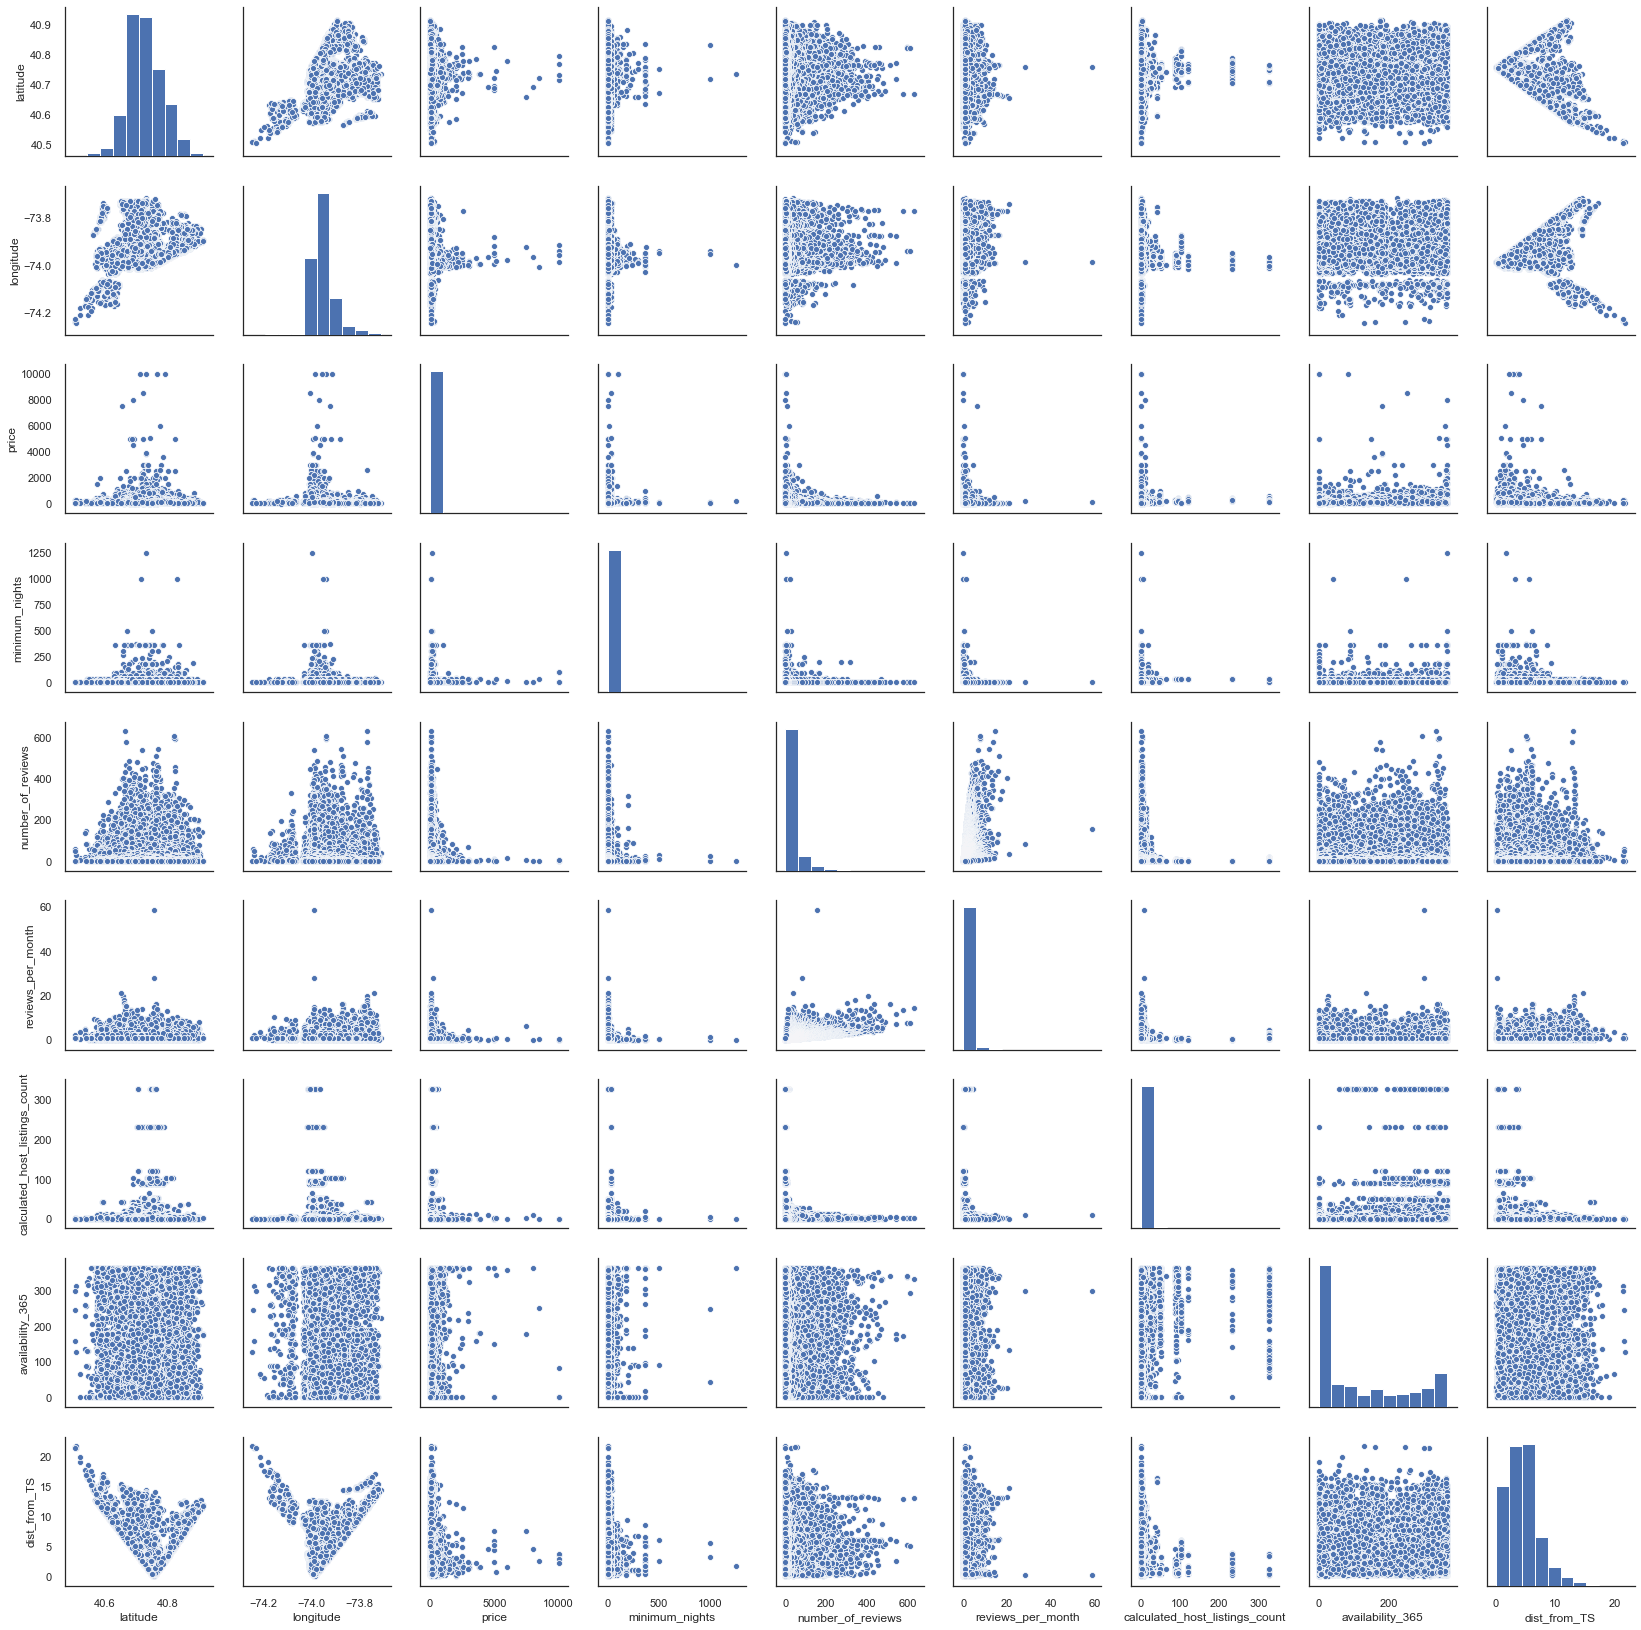

In [68]:
sns.pairplot(df)

In [69]:
df['price'].describe()

count    38821.000000
mean       142.332526
std        196.994756
min          0.000000
25%         69.000000
50%        101.000000
75%        170.000000
max      10000.000000
Name: price, dtype: float64

In [70]:
#Getting rid of outliers of price from both low end (under $25) and high end (above $300)
df = df[df["price"]<300]
df = df[df["price"]>25]
df['price'].describe()

count    36086.000000
mean       115.292302
std         61.611922
min         26.000000
25%         65.000000
50%        100.000000
75%        150.000000
max        299.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'Price & Neighbourhood Group')

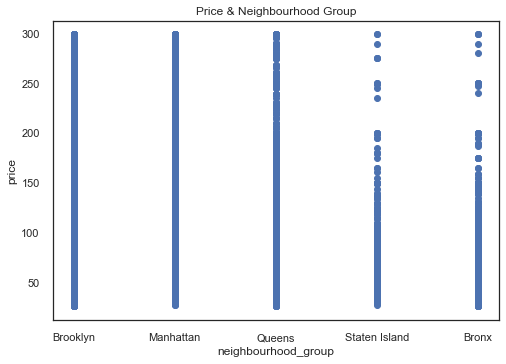

In [71]:
plt.scatter(df['neighbourhood_group'], df['price'])
plt.xlabel('neighbourhood_group')
plt.ylabel('price')
plt.title('Price & Neighbourhood Group')

Text(0.5, 1.0, 'Price & Neighbourhood')

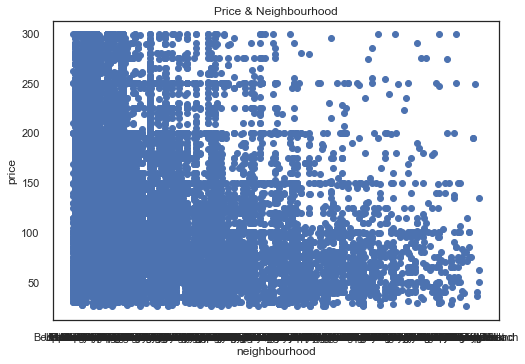

In [72]:
plt.scatter(df['neighbourhood'], df['price'])
plt.xlabel('neighbourhood')
plt.ylabel('price')
plt.title('Price & Neighbourhood')

Text(0.5, 1.0, 'Price & Room Type')

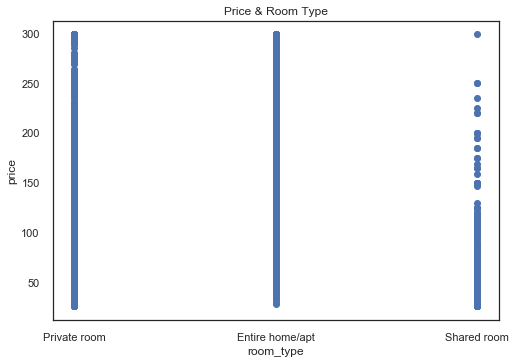

In [73]:
plt.scatter(df['room_type'], df['price'])
plt.xlabel('room_type')
plt.ylabel('price')
plt.title('Price & Room Type')

Text(0.5, 1.0, 'Price & Number of Reviews')

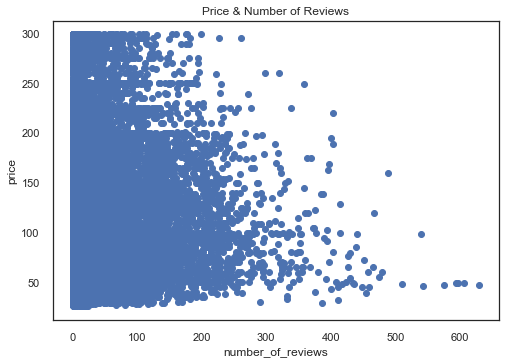

In [74]:
plt.scatter(df['number_of_reviews'], df['price'])
plt.xlabel('number_of_reviews')
plt.ylabel('price')
plt.title('Price & Number of Reviews')

Text(0.5, 1.0, 'Price & Review Per Month')

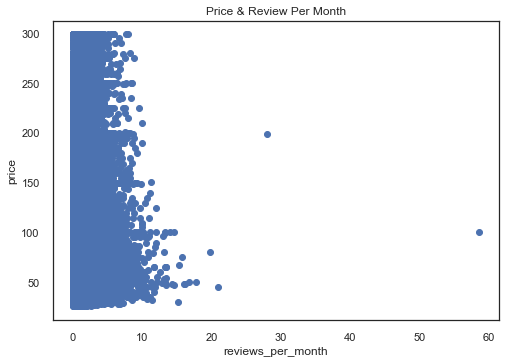

In [75]:
plt.scatter(df['reviews_per_month'], df['price'])
plt.xlabel('reviews_per_month')
plt.ylabel('price')
plt.title('Price & Review Per Month')

Text(0.5, 1.0, 'AirBnB')

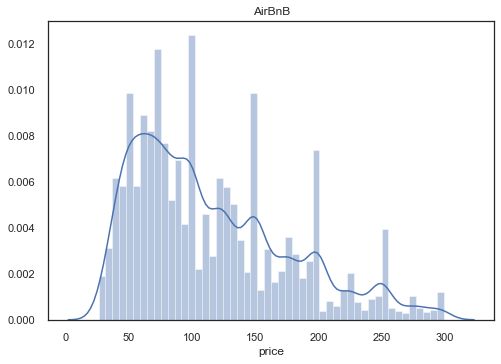

In [76]:
sns.distplot(df.price).set_title('AirBnB') #checked to see the skewness of target variable of price

Create dummy variables for Neighborhood groups and room types

In [77]:
neighbourhood_g = pd.get_dummies(df.neighbourhood_group).iloc[:, 1:]  #creating dummies for categorical variables
room_t = pd.get_dummies(df.room_type).iloc[:, 1:]

df = pd.concat([df, neighbourhood_g, room_t], axis = 1)  #concatting dummies into original Data Frame

## Data Visualization

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

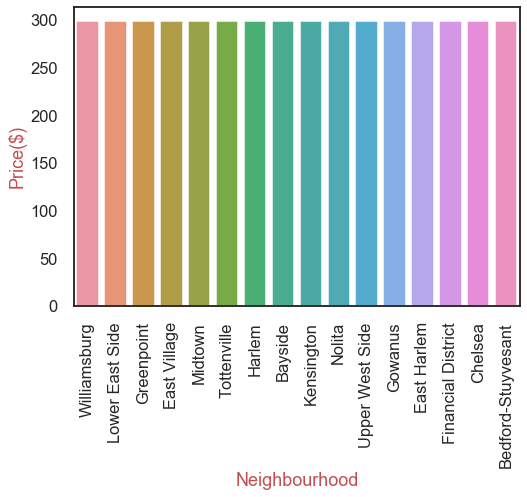

In [78]:
sns.set_context("talk",font_scale=1.0)
ax=sns.barplot('neighbourhood','price',data = df.nlargest(20,'price'),ci=None)
plt.xlabel("Neighbourhood",color='r')
plt.ylabel("Price($)",color='r')
plt.xticks(rotation=90)

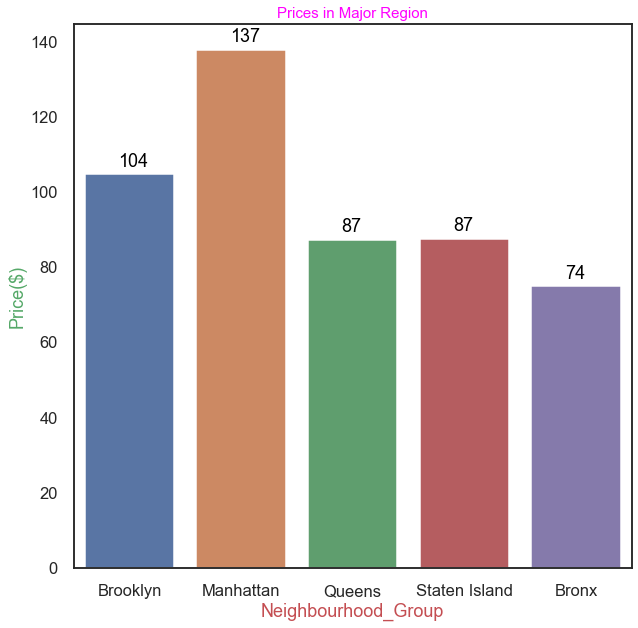

In [79]:
figure,ax = plt.subplots(figsize=(10,10))
sns.set_context('talk')
ax=sns.barplot(x = df['neighbourhood_group'],y = df['price'],ci=None)
plt.xlabel("Neighbourhood_Group",color='r')
plt.ylabel("Price($)",color='g')
plt.title("Prices in Major Region",color='magenta',size=15)

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.30, p.get_height()+1), va='bottom',
                    color= 'black')

- Shows that price is influenced by the borough the Airbnb is located in; Manhattan having the highest average of price.


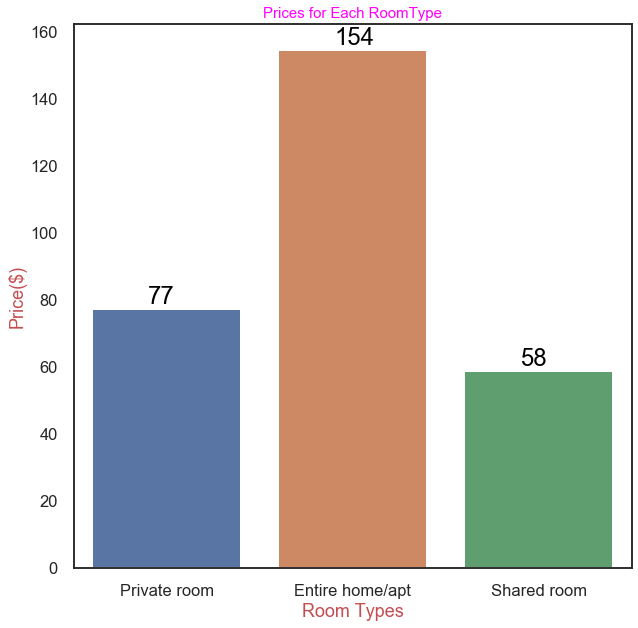

In [80]:
figure,ax = plt.subplots(figsize=(10,10))
sns.set_context('poster')
ax = sns.barplot(df['room_type'],df['price'],ci=None)
plt.xlabel("Room Types",color='r')
plt.ylabel("Price($)",color='r')
plt.title("Prices for Each RoomType",color='magenta',size=15)

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.30, p.get_height()-0.05), va='bottom',
                    color= 'black')

- Shows that price is influenced by the type of room in the Airbnb (whether a shared or private room/Entire home). Renting an Entire home has the highest price

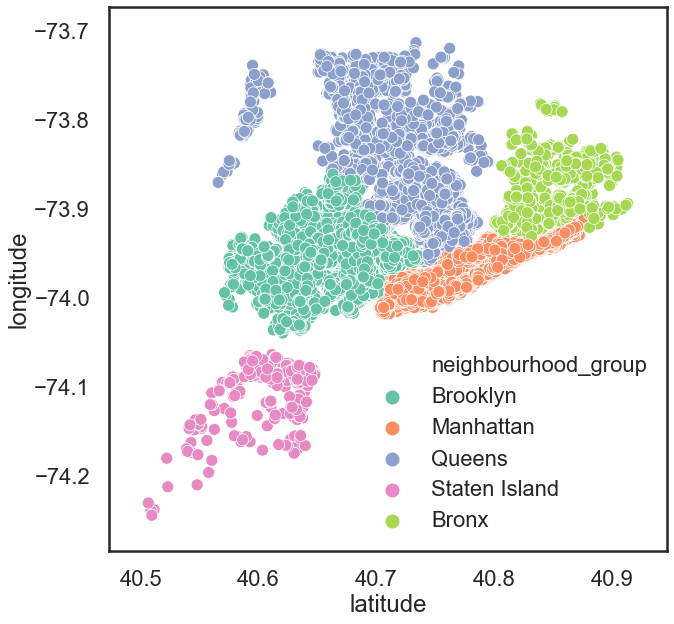

In [81]:
figure,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=df['latitude'],y=df['longitude'],hue=df['neighbourhood_group'],data=df,palette='Set2')

- Outlining the coordinates of different boroughs

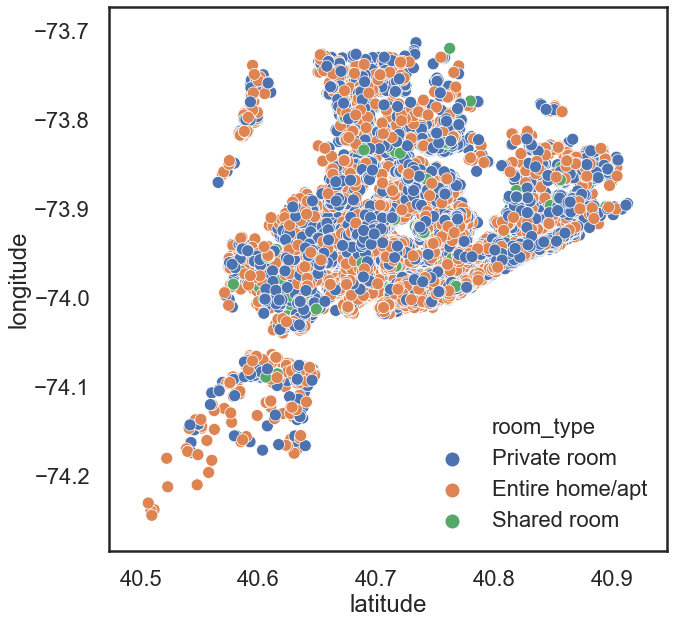

In [82]:
figure,ax = plt.subplots(figsize=(10,10))
sns.set_style('white')
sns.scatterplot(x=df['latitude'],y=df['longitude'],hue=df['room_type'],data=df,sizes='size',
               markers="markers")

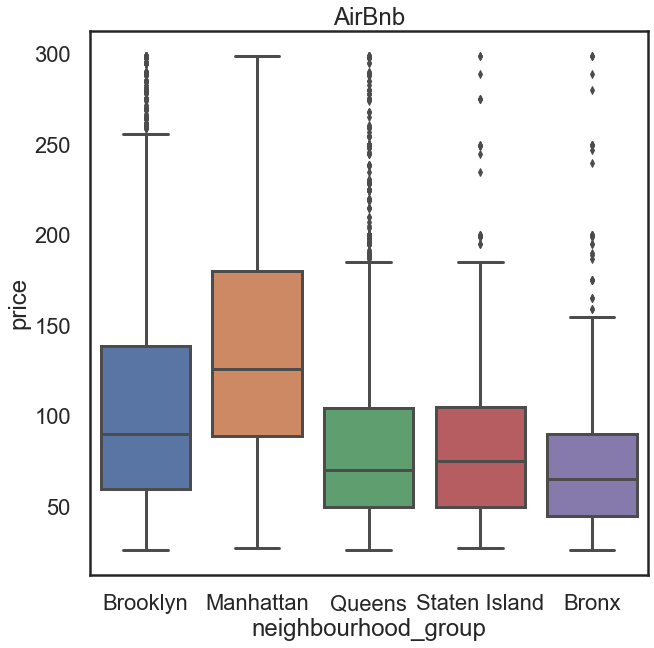

In [83]:

figure,ax = plt.subplots(figsize=(10,10))  #boxplot of price & neighborhood groups
sns.boxplot(x = "neighbourhood_group", y = "price", data = df).set_title("AirBnb")
plt.savefig('Box_NGroup.png')

Shows that price is influenced by the borough the Airbnb is located in; Manhattan having the highest average of price.



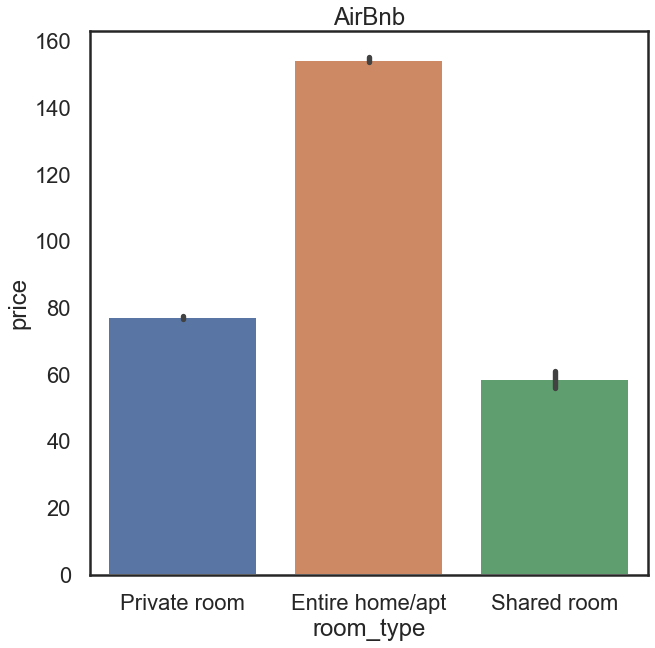

In [84]:
figure,ax = plt.subplots(figsize=(10,10))  #bar graph of price & room types
sns.barplot(x = "room_type", y = "price", data = df).set_title("AirBnb")
plt.savefig('Bar_Room.png')

Shows that Entire home/apt room type offers the highest price



Text(0.5, 1.0, 'Neighbourhood Group')

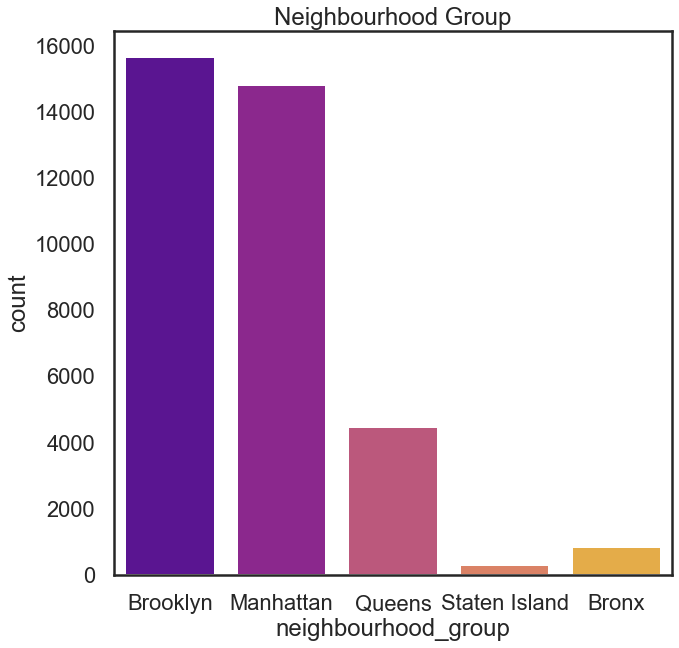

In [85]:
sns.countplot(df['neighbourhood_group'], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Neighbourhood Group')

- This shows that there is a major gap of Airbnb's available between Brooklyn and Manhattan, and Queens, Staten Island, and the Bronx. Brooklyn has a slight lead over Manhattan with the most listings.

In [86]:
df = pd.concat([df, pd.get_dummies(df['neighbourhood'])], 1)
df = pd.concat([df, pd.get_dummies(df['room_type'])], 1)
df_dropped = df.drop(['neighbourhood_group', 'neighbourhood', 'room_type', 'latitude', 'longitude', 'coordinates'], axis = 1)
df_dropped

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,dist_from_TS,Brooklyn,Manhattan,Queens,...,Williamsbridge,Williamsburg,Willowbrook,Windsor Terrace,Woodhaven,Woodlawn,Woodside,Entire home/apt,Private room,Shared room
0,149,1,9,0.21,6,365,7.520408,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,225,1,45,0.38,2,355,0.235124,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,89,1,270,4.64,1,194,5.089206,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,80,10,9,0.10,1,0,3.709244,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,200,3,74,0.59,1,129,0.851855,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48782,129,1,1,1.00,1,147,2.464747,0,1,0,...,0,0,0,0,0,0,0,0,1,0
48790,45,1,1,1.00,6,339,9.058410,0,0,1,...,0,0,0,0,0,0,0,0,1,0
48799,235,1,1,1.00,1,87,16.887427,0,0,0,...,0,0,0,0,0,0,0,0,1,0
48805,100,1,2,2.00,1,40,4.879952,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [87]:
df.rename(columns = {"Upper East Side": "Upper_East_Side", "Upper West Side": "Upper_West_Side"}, inplace = True)
df.head() #renamed columns to display better on axis

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,...,Williamsbridge,Williamsburg,Willowbrook,Windsor Terrace,Woodhaven,Woodlawn,Woodside,Entire home/apt,Private room,Shared room
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,...,0,0,0,0,0,0,0,0,1,0
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,...,0,0,0,0,0,0,0,1,0,0
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,...,0,0,0,0,0,0,0,1,0,0
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,...,0,0,0,0,0,0,0,1,0,0
5,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,1,...,0,0,0,0,0,0,0,1,0,0


# Hypothesis Testing

In [88]:
from scipy import stats

### 1. Anova Test

- H0: There is no difference between the mean price across neighborhoods 
- HA: There is a difference between the mean price across neighborhoods  
- Conclusion: We CAN reject the null hypothesis because our pvalue is less than 0.05 (alpha set at .05)



In [110]:
stats.f_oneway(df["price"][df['neighbourhood_group'] == 'Manhattan'],
                df['price'][df['neighbourhood_group'] == 'Brooklyn'], 
                df['price'][df['neighbourhood_group'] == 'Queens'])
                


F_onewayResult(statistic=1855.6827848492167, pvalue=0.0)

### 2. Anova Test


- H0: There is no difference between the mean price across room types 
- HA: There is a difference between the mean price across room types
- Conclusion: We CAN reject the null hypothesis because our pvalue is less than 0.05 (alpha set at .05)

In [ ]:
stats.f_oneway(df["price"][df['room_type'] == 'Entire home/apt'],
                df['price'][df['room_type'] == 'Private room'], 
                df['price'][df['room_type'] == 'Shared room'])

### 3. One Sample T Test

In [ ]:
ttest_distance_cc = stats.ttest_ind(df[df['dist_from_TS'] < 5]['price'], df[df['dist_from_TS'] >=5]['price']) 
ttest_distance_cc

# Modeling


In [90]:
df_dummy = list(df_dropped.columns) 
df_dummy = df_dummy[1:]

### Linear Regression With Original Features From Data Set

In [91]:
mlr_model = ols(formula = "price ~ neighbourhood_group + neighbourhood + latitude + longitude + room_type + minimum_nights + number_of_reviews + reviews_per_month + calculated_host_listings_count + availability_365", data = df).fit()  #Without scaling the numbers
mlr_model.summary()  #output of all my features that wern't dropped that came with dataset




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     193.9
Date:                Thu, 30 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:02:24   Log-Likelihood:            -1.8550e+05
No. Observations:               36086   AIC:                         3.715e+05
Df Residuals:                   35859   BIC:                         3.734e+05
Df Model:                         226                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                   -2.583e+04   2779.834     -9.291      0.000   -3.13e+04   -2.04e+04
neighbourhood_group[T.Brooklyn]               -37.8492     11.019     -3.435      0.001     -59.446     -16.252
neighbourhood_group[T.Manhattan]               -1.7182      8.618     -0.199      0.842     -18.610      15.173
neighbourhood_group[T.Queens]                  15.7928      9.488      1.665      0.096      -2.803      34.389
neighbourhood_group[T.Staten Island]         -127.1841     14.851     -8.564      0.000    -156.292     -98.076
neighbourhood[T.Arden Heights]                -59.9426     20.704     -2.895      0.004    -100.524     -19.361
neighbourhood[T.Arrochar]                      18.6007     10.048      1.851      0.064      -1.094      38.296
neighbourhood[T.Arverne]                       16.3074      7.226      2.257      0.024       2.144      30.471
neighbourhood[T.Astoria]                      -33.4061      4.386     -7.616      0.000     -42.003     -24.809
neighbourhood[T.Bath Beach]                   -44.2739     10.816     -4.093      0.000     -65.473     -23.075
neighbourhood[T.Battery Park City]             -8.4909      7.578     -1.121      0.262     -23.343       6.361
neighbourhood[T.Bay Ridge]                    -37.9511      4.537     -8.365      0.000     -46.843     -29.059
neighbourhood[T.Bay Terrace]                   49.6577     18.537      2.679      0.007      13.325      85.991
neighbourhood[T.Bay Terrace, Staten Island]   -18.3870     28.894     -0.636      0.525     -75.020      38.246
neighbourhood[T.Baychester]                    -3.5982     18.292     -0.197      0.844     -39.452      32.255
neighbourhood[T.Bayside]                       28.4003      8.029      3.537      0.000      12.663      44.138
neighbourhood[T.Bayswater]                     12.0866     13.134      0.920      0.357     -13.655      37.829
neighbourhood[T.Bedford-Stuyvesant]             4.5324      1.884      2.406      0.016       0.840       8.225
neighbourhood[T.Belle Harbor]                  41.7817     18.971      2.202      0.028       4.598      78.965
neighbourhood[T.Bellerose]                     46.6504     14.768      3.159      0.002      17.705      75.596
neighbourhood[T.Belmont]                        2.8125     11.794      0.238      0.812     -20.305      25.930
neighbourhood[T.Bensonhurst]                  -39.0053      5.708     -6.833      0.000     -50.194     -27.817
neighbourhood[T.Bergen Beach]                  -9.7115     14.561     -0.667      0.505     -38.251      18.828
neighbourhood[T.Boerum Hill]                   14.7151      3.902      3.771      0.000       7.067      22.364
neighbourhood[T.Borough Park]                 -39.0917     

- In this context, the R^2 value tells us how much of the variation in Price is explained by the features I included in the model, such as Neighbourhood Group, Neighbourhood, and Room Type.

## Linear Regression With Added Feature: 
Feature Added:

- Distance From Times Square

In [92]:
mlr_model = ols(formula = "price ~ neighbourhood_group + neighbourhood + latitude + longitude + room_type + minimum_nights + number_of_reviews + reviews_per_month + calculated_host_listings_count + availability_365 + dist_from_TS", data = df).fit()  #Without scaling the numbers
mlr_model.summary()  #output of all my features that wern't dropped that came with dataset




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     194.4
Date:                Thu, 30 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:02:27   Log-Likelihood:            -1.8543e+05
No. Observations:               36086   AIC:                         3.713e+05
Df Residuals:                   35858   BIC:                         3.733e+05
Df Model:                         227                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                   -2782.6832   3433.526     -0.810      0.418   -9512.498    3947.131
neighbourhood_group[T.Brooklyn]               -33.6119     11.005     -3.054      0.002     -55.183     -12.041
neighbourhood_group[T.Manhattan]              -26.6481      8.876     -3.002      0.003     -44.046      -9.250
neighbourhood_group[T.Queens]                   0.2182      9.569      0.023      0.982     -18.537      18.973
neighbourhood_group[T.Staten Island]          -32.3530     17.000     -1.903      0.057     -65.674       0.968
neighbourhood[T.Arden Heights]                -10.8581     21.111     -0.514      0.607     -52.237      30.521
neighbourhood[T.Arrochar]                      -4.5195     10.233     -0.442      0.659     -24.578      15.538
neighbourhood[T.Arverne]                       45.1559      7.645      5.907      0.000      30.172      60.139
neighbourhood[T.Astoria]                      -54.1324      4.741    -11.418      0.000     -63.425     -44.840
neighbourhood[T.Bath Beach]                    -8.9955     11.231     -0.801      0.423     -31.009      13.019
neighbourhood[T.Battery Park City]              6.0970      7.672      0.795      0.427      -8.939      21.133
neighbourhood[T.Bay Ridge]                     -9.5519      5.169     -1.848      0.065     -19.683       0.579
neighbourhood[T.Bay Terrace]                   46.8087     18.505      2.529      0.011      10.537      83.080
neighbourhood[T.Bay Terrace, Staten Island]     9.3470     28.945      0.323      0.747     -47.386      66.080
neighbourhood[T.Baychester]                     0.1546     18.263      0.008      0.993     -35.641      35.950
neighbourhood[T.Bayside]                       25.2536      8.019      3.149      0.002       9.535      40.972
neighbourhood[T.Bayswater]                     36.3172     13.281      2.734      0.006      10.286      62.349
neighbourhood[T.Bedford-Stuyvesant]           -18.2425      2.744     -6.648      0.000     -23.621     -12.864
neighbourhood[T.Belle Harbor]                  80.0812     19.233      4.164      0.000      42.385     117.778
neighbourhood[T.Bellerose]                     48.6032     14.742      3.297      0.001      19.707      77.499
neighbourhood[T.Belmont]                       -0.8171     11.777     -0.069      0.945     -23.901      22.267
neighbourhood[T.Bensonhurst]                  -12.2881      6.162     -1.994      0.046     -24.365      -0.211
neighbourhood[T.Bergen Beach]                  -6.7445     14.537     -0.464      0.643     -35.238      21.749
neighbourhood[T.Boerum Hill]                    0.7715      4.083      0.189      0.850      -7.231       8.774
neighbourhood[T.Borough Park]                 -24.1097     

## Linear Regression: Dropped Features
Features Dropped:
- Latitude
- Longitude
- Coordinates
- Neighborhood
- Neighborhood Groups
- Room Type

In [113]:
mlr_model = ols(formula = "price ~ reviews_per_month + + number_of_reviews + minimum_nights + calculated_host_listings_count + availability_365 + dist_from_TS", data = df).fit()  #Without scaling the numbers
mlr_model.summary()  #output of all my features that wern't dropped that came with dataset



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     1037.
Date:                Thu, 30 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:20:51   Log-Likelihood:            -1.9704e+05
No. Observations:               36086   AIC:                         3.941e+05
Df Residuals:                   36079   BIC:                         3.941e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        149.2643      0.655    228.055      0.000     147.981     150.547
reviews_per_month                 -0.3599      0.217     -1.657      0.098      -0.785       0.066
number_of_reviews                 -0.0048      0.007     -0.645      0.519      -0.019       0.010
minimum_nights                    -0.0765      0.017     -4.402      0.000      -0.111      -0.042
calculated_host_listings_count     0.2237      0.013     17.582      0.000       0.199       0.249
availability_365                   0.0358      0.002     14.388      0.000       0.031       0.041
dist_from_TS                      -8.2777      0.113    -73.555      0.000      -8.498      -8.057
==============================================================================
Omnibus:                     3640.236   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4832.820
Skew:                           0.874   Prob(JB):                         0.00
Kurtosis:                       3.397   Cond. No.                         381.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
#A function to quickly run a linear regression model on a dataframe
def test_train(abc):
    target = abc['price']
    df_features= abc.drop(columns= ['price'])
    X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=34,test_size=0.2)
    scaler = StandardScaler()
    # fit the scaler to the training data
    scaler.fit(X_train)
    #transform the training data
    X_train = pd.DataFrame(data=scaler.transform(X_train), columns=df_features.columns)
    #transform the testing dat
    X_test = pd.DataFrame(data=scaler.transform(X_test), columns=df_features.columns)
    lm_2 = LinearRegression()
    #fit the linear regression to the data
    lm_2 = lm_2.fit(X_train, y_train)
    y_train_pred = lm_2.predict(X_train)
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    print('Training RMSE:' , train_rmse)
    # use fitted model to predict on test data
    y_pred = lm_2.predict(X_test)
    test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('Testing RMSE:' , test_rmse)
    print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))
    print('R^2 for training data:', lm_2.score(X_train, y_train))
    print('R^2 for testing data:', lm_2.score(X_test, y_test))
    print('Testing Error:', test_rmse/y_train.std()) 
    return

Checking the RMSE based on the data set with dropped variables

## Regression Model with dropped features

In [108]:
test_train(df_dropped)

Training RMSE: 41.187574387758374
Testing RMSE: 13682215210755.047
Training:  41 vs. Testing:  13682215210755
R^2 for training data: 0.5509662171389845
R^2 for testing data: -4.841757903456023e+22
Testing Error: 222598476099.08868


## Lasso Model

In [106]:
## training the model

lm_2 = LinearRegression()
    #fit the linear regression to the data
lm_2 = lm_2.fit(X_train, y_train)
target = df_dropped['price']
df_features= df_dropped.drop(columns= ['price'])
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=34,test_size=0.2)
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01, normalize=True)

lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

train_rmse = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training RMSE: '+ str(train_rmse) )
print('Testing RMSE: '+ str(test_rmse) )
print('R^2 for training data:', lm_2.score(X_train, y_train))
print('R^2 for testing data:', lm_2.score(X_test, y_test))


Training RMSE: 32.01561411390601
Testing RMSE: 43.08744731924042
R^2 for training data: 0.551089329368305
R^2 for testing data: -3759236476604.6064


### The Modeling Process and Interpretation


The approach I took to this project was to  find a data set of different Airbnb's in NYC that had enough columns(features) for me to engineer. This would allow me to make the best possible predictions for a model. Although I have rented AirBnb's in the past, I wanted to see if my predictions of specific features would be a direct influence on my target variable (price). Along the way, I kept in mind which features might be interesting to engineer (distance from Time Square, the epicenter of New York City), as well as visualizations to help to help visualize my various correlations. 

I ran three OLS models. The first wwas run with all of the nescesary columns from the original data set. Essentially, anything that was not dropped early on, was kept in. This model ran with an R^2 of 0.550. The second OLS model I ran, I inputted the distance from Times Square alongside the original data I kept in. This increased the R^2 to 0.552, a slight improvement. Lastly, the third OLS OLS model I ran I dropped five features: Latitude, Longitude, Coordinates, Minimum Nights, Number Of Reviews. This significantly decreased the r^2 to 0.547.

When I did regular regression my testing RMSE was way higher than your training RMSE which means my model was overfitting for the training data. But when I did the Lasso regression the testing area decreased tremendously. Lasso regression is really good to use when your model is being overfit to the training data because it introduces a BIAS which then lowers the variance and lowered your RMSE and better fit your testing data